## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.3.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [2]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


Dataset emotion downloaded and prepared to C:\Users\KIIT\AppData\Roaming\SPB_Data\.cache\huggingface\datasets\emotion\default\0.0.0\84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [3]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [4]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [5]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data]
    return tweets, labels

In [6]:
tweets, labels = get_tweets(train)

In [7]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

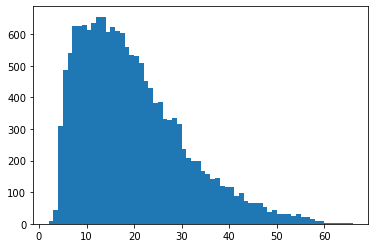

In [10]:
lengths = [len(t.split(' ')) for t in tweets]

plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [13]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [14]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [15]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'anger', 'sadness', 'love', 'fear'}


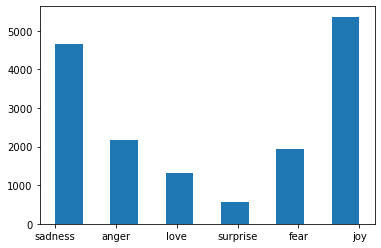

In [16]:
plt.hist(labels, bins=11)
plt.show()

In [17]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [18]:
classes_to_index

{'surprise': 0, 'joy': 1, 'anger': 2, 'sadness': 3, 'love': 4, 'fear': 5}

In [19]:
index_to_classes

{0: 'surprise', 1: 'joy', 2: 'anger', 3: 'sadness', 4: 'love', 5: 'fear'}

In [20]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [21]:
train_labels = names_to_ids(labels)
print(train_labels[0])

3


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [23]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [24]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 3)

In [25]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20


215/500 [===========>..................] - ETA: 0s - loss: 1.7913 - accuracy: 0.21 - ETA: 16s - loss: 1.7893 - accuracy: 0.218 - ETA: 20s - loss: 1.7875 - accuracy: 0.218 - ETA: 22s - loss: 1.7844 - accuracy: 0.234 - ETA: 23s - loss: 1.7823 - accuracy: 0.262 - ETA: 23s - loss: 1.7798 - accuracy: 0.296 - ETA: 23s - loss: 1.7769 - accuracy: 0.308 - ETA: 24s - loss: 1.7741 - accuracy: 0.300 - ETA: 24s - loss: 1.7731 - accuracy: 0.295 - ETA: 24s - loss: 1.7685 - accuracy: 0.293 - ETA: 24s - loss: 1.7676 - accuracy: 0.286 - ETA: 24s - loss: 1.7670 - accuracy: 0.286 - ETA: 24s - loss: 1.7641 - accuracy: 0.293 - ETA: 24s - loss: 1.7619 - accuracy: 0.292 - ETA: 24s - loss: 1.7586 - accuracy: 0.283 - ETA: 24s - loss: 1.7553 - accuracy: 0.285 - ETA: 24s - loss: 1.7522 - accuracy: 0.286 - ETA: 24s - loss: 1.7473 - accuracy: 0.283 - ETA: 24s - loss: 1.7434 - accuracy: 0.284 - ETA: 24s - loss: 1.7375 - accuracy: 0.284 - ETA: 24s - loss: 1.7381 - accuracy: 0.281 - ETA: 24s - loss: 1.7370 - accuracy:

452/500 [==========================>...] - ETA: 14s - loss: 1.5641 - accuracy: 0.363 - ETA: 14s - loss: 1.5633 - accuracy: 0.364 - ETA: 14s - loss: 1.5601 - accuracy: 0.366 - ETA: 14s - loss: 1.5598 - accuracy: 0.366 - ETA: 14s - loss: 1.5596 - accuracy: 0.366 - ETA: 14s - loss: 1.5588 - accuracy: 0.367 - ETA: 14s - loss: 1.5578 - accuracy: 0.368 - ETA: 14s - loss: 1.5581 - accuracy: 0.367 - ETA: 14s - loss: 1.5575 - accuracy: 0.368 - ETA: 14s - loss: 1.5569 - accuracy: 0.368 - ETA: 14s - loss: 1.5571 - accuracy: 0.368 - ETA: 14s - loss: 1.5564 - accuracy: 0.368 - ETA: 14s - loss: 1.5546 - accuracy: 0.370 - ETA: 14s - loss: 1.5527 - accuracy: 0.371 - ETA: 14s - loss: 1.5515 - accuracy: 0.371 - ETA: 14s - loss: 1.5513 - accuracy: 0.372 - ETA: 14s - loss: 1.5504 - accuracy: 0.372 - ETA: 13s - loss: 1.5496 - accuracy: 0.373 - ETA: 13s - loss: 1.5490 - accuracy: 0.373 - ETA: 13s - loss: 1.5483 - accuracy: 0.374 - ETA: 13s - loss: 1.5475 - accuracy: 0.374 - ETA: 13s - loss: 1.5463 - accurac

500/500 [==============================] - ETA: 2s - loss: 1.2943 - accuracy: 0.49 - ETA: 2s - loss: 1.2939 - accuracy: 0.49 - ETA: 2s - loss: 1.2930 - accuracy: 0.50 - ETA: 2s - loss: 1.2919 - accuracy: 0.50 - ETA: 2s - loss: 1.2904 - accuracy: 0.50 - ETA: 2s - loss: 1.2898 - accuracy: 0.50 - ETA: 2s - loss: 1.2888 - accuracy: 0.50 - ETA: 2s - loss: 1.2874 - accuracy: 0.50 - ETA: 2s - loss: 1.2859 - accuracy: 0.50 - ETA: 1s - loss: 1.2850 - accuracy: 0.50 - ETA: 1s - loss: 1.2838 - accuracy: 0.50 - ETA: 1s - loss: 1.2825 - accuracy: 0.50 - ETA: 1s - loss: 1.2818 - accuracy: 0.50 - ETA: 1s - loss: 1.2810 - accuracy: 0.50 - ETA: 1s - loss: 1.2798 - accuracy: 0.50 - ETA: 1s - loss: 1.2786 - accuracy: 0.50 - ETA: 1s - loss: 1.2780 - accuracy: 0.50 - ETA: 1s - loss: 1.2770 - accuracy: 0.50 - ETA: 1s - loss: 1.2756 - accuracy: 0.50 - ETA: 1s - loss: 1.2746 - accuracy: 0.50 - ETA: 1s - loss: 1.2735 - accuracy: 0.50 - ETA: 1s - loss: 1.2725 - accuracy: 0.50 - ETA: 1s - loss: 1.2711 - accuracy

251/500 [==============>...............] - ETA: 0s - loss: 0.5336 - accuracy: 0.78 - ETA: 14s - loss: 0.5312 - accuracy: 0.812 - ETA: 19s - loss: 0.6424 - accuracy: 0.796 - ETA: 20s - loss: 0.6152 - accuracy: 0.775 - ETA: 20s - loss: 0.6431 - accuracy: 0.785 - ETA: 21s - loss: 0.6267 - accuracy: 0.789 - ETA: 22s - loss: 0.6237 - accuracy: 0.788 - ETA: 22s - loss: 0.6160 - accuracy: 0.784 - ETA: 23s - loss: 0.6353 - accuracy: 0.770 - ETA: 23s - loss: 0.6470 - accuracy: 0.762 - ETA: 23s - loss: 0.6365 - accuracy: 0.767 - ETA: 23s - loss: 0.6296 - accuracy: 0.769 - ETA: 23s - loss: 0.6276 - accuracy: 0.777 - ETA: 23s - loss: 0.6152 - accuracy: 0.783 - ETA: 23s - loss: 0.6019 - accuracy: 0.787 - ETA: 23s - loss: 0.5885 - accuracy: 0.797 - ETA: 23s - loss: 0.5819 - accuracy: 0.799 - ETA: 22s - loss: 0.5836 - accuracy: 0.793 - ETA: 22s - loss: 0.5838 - accuracy: 0.791 - ETA: 23s - loss: 0.5802 - accuracy: 0.792 - ETA: 23s - loss: 0.5786 - accuracy: 0.794 - ETA: 23s - loss: 0.5799 - accuracy:

500/500 [==============================] - ETA: 12s - loss: 0.5760 - accuracy: 0.802 - ETA: 12s - loss: 0.5762 - accuracy: 0.802 - ETA: 12s - loss: 0.5756 - accuracy: 0.802 - ETA: 12s - loss: 0.5759 - accuracy: 0.802 - ETA: 12s - loss: 0.5759 - accuracy: 0.802 - ETA: 12s - loss: 0.5756 - accuracy: 0.803 - ETA: 12s - loss: 0.5762 - accuracy: 0.802 - ETA: 12s - loss: 0.5760 - accuracy: 0.802 - ETA: 12s - loss: 0.5756 - accuracy: 0.802 - ETA: 12s - loss: 0.5749 - accuracy: 0.802 - ETA: 11s - loss: 0.5741 - accuracy: 0.803 - ETA: 11s - loss: 0.5731 - accuracy: 0.804 - ETA: 11s - loss: 0.5733 - accuracy: 0.803 - ETA: 11s - loss: 0.5740 - accuracy: 0.803 - ETA: 11s - loss: 0.5742 - accuracy: 0.803 - ETA: 11s - loss: 0.5741 - accuracy: 0.803 - ETA: 11s - loss: 0.5738 - accuracy: 0.803 - ETA: 11s - loss: 0.5736 - accuracy: 0.803 - ETA: 11s - loss: 0.5733 - accuracy: 0.803 - ETA: 11s - loss: 0.5736 - accuracy: 0.803 - ETA: 11s - loss: 0.5738 - accuracy: 0.803 - ETA: 11s - loss: 0.5736 - accurac

236/500 [=============>................] - ETA: 0s - loss: 0.3359 - accuracy: 0.87 - ETA: 14s - loss: 0.3024 - accuracy: 0.890 - ETA: 18s - loss: 0.3502 - accuracy: 0.890 - ETA: 19s - loss: 0.3243 - accuracy: 0.906 - ETA: 20s - loss: 0.3217 - accuracy: 0.901 - ETA: 20s - loss: 0.3236 - accuracy: 0.895 - ETA: 20s - loss: 0.3094 - accuracy: 0.900 - ETA: 20s - loss: 0.3185 - accuracy: 0.891 - ETA: 20s - loss: 0.3090 - accuracy: 0.895 - ETA: 20s - loss: 0.3050 - accuracy: 0.898 - ETA: 20s - loss: 0.3031 - accuracy: 0.899 - ETA: 20s - loss: 0.3092 - accuracy: 0.896 - ETA: 21s - loss: 0.3089 - accuracy: 0.896 - ETA: 21s - loss: 0.3053 - accuracy: 0.898 - ETA: 21s - loss: 0.3047 - accuracy: 0.899 - ETA: 21s - loss: 0.3083 - accuracy: 0.898 - ETA: 21s - loss: 0.3202 - accuracy: 0.893 - ETA: 21s - loss: 0.3241 - accuracy: 0.891 - ETA: 21s - loss: 0.3267 - accuracy: 0.888 - ETA: 21s - loss: 0.3235 - accuracy: 0.890 - ETA: 21s - loss: 0.3221 - accuracy: 0.889 - ETA: 21s - loss: 0.3293 - accuracy:

471/500 [===========================>..] - ETA: 13s - loss: 0.3397 - accuracy: 0.886 - ETA: 13s - loss: 0.3393 - accuracy: 0.886 - ETA: 13s - loss: 0.3390 - accuracy: 0.886 - ETA: 13s - loss: 0.3384 - accuracy: 0.887 - ETA: 13s - loss: 0.3384 - accuracy: 0.887 - ETA: 13s - loss: 0.3379 - accuracy: 0.887 - ETA: 13s - loss: 0.3386 - accuracy: 0.886 - ETA: 13s - loss: 0.3391 - accuracy: 0.886 - ETA: 12s - loss: 0.3390 - accuracy: 0.886 - ETA: 12s - loss: 0.3386 - accuracy: 0.886 - ETA: 12s - loss: 0.3379 - accuracy: 0.886 - ETA: 12s - loss: 0.3386 - accuracy: 0.886 - ETA: 12s - loss: 0.3384 - accuracy: 0.886 - ETA: 12s - loss: 0.3379 - accuracy: 0.886 - ETA: 12s - loss: 0.3374 - accuracy: 0.886 - ETA: 12s - loss: 0.3376 - accuracy: 0.886 - ETA: 12s - loss: 0.3385 - accuracy: 0.886 - ETA: 12s - loss: 0.3375 - accuracy: 0.886 - ETA: 12s - loss: 0.3371 - accuracy: 0.886 - ETA: 12s - loss: 0.3373 - accuracy: 0.886 - ETA: 12s - loss: 0.3386 - accuracy: 0.886 - ETA: 12s - loss: 0.3385 - accurac

500/500 [==============================] - ETA: 1s - loss: 0.3270 - accuracy: 0.88 - ETA: 1s - loss: 0.3266 - accuracy: 0.88 - ETA: 1s - loss: 0.3272 - accuracy: 0.88 - ETA: 1s - loss: 0.3271 - accuracy: 0.88 - ETA: 1s - loss: 0.3273 - accuracy: 0.88 - ETA: 1s - loss: 0.3276 - accuracy: 0.88 - ETA: 1s - loss: 0.3272 - accuracy: 0.88 - ETA: 0s - loss: 0.3275 - accuracy: 0.88 - ETA: 0s - loss: 0.3272 - accuracy: 0.88 - ETA: 0s - loss: 0.3273 - accuracy: 0.88 - ETA: 0s - loss: 0.3276 - accuracy: 0.88 - ETA: 0s - loss: 0.3279 - accuracy: 0.88 - ETA: 0s - loss: 0.3277 - accuracy: 0.88 - ETA: 0s - loss: 0.3275 - accuracy: 0.88 - ETA: 0s - loss: 0.3277 - accuracy: 0.88 - ETA: 0s - loss: 0.3274 - accuracy: 0.88 - ETA: 0s - loss: 0.3267 - accuracy: 0.88 - ETA: 0s - loss: 0.3267 - accuracy: 0.88 - ETA: 0s - loss: 0.3276 - accuracy: 0.88 - ETA: 0s - loss: 0.3287 - accuracy: 0.88 - ETA: 0s - loss: 0.3287 - accuracy: 0.88 - ETA: 0s - loss: 0.3284 - accuracy: 0.88 - ETA: 0s - loss: 0.3282 - accuracy

231/500 [============>.................] - ETA: 0s - loss: 0.2615 - accuracy: 0.90 - ETA: 17s - loss: 0.1977 - accuracy: 0.937 - ETA: 21s - loss: 0.2183 - accuracy: 0.916 - ETA: 22s - loss: 0.2553 - accuracy: 0.898 - ETA: 23s - loss: 0.2232 - accuracy: 0.912 - ETA: 24s - loss: 0.2203 - accuracy: 0.916 - ETA: 23s - loss: 0.2693 - accuracy: 0.890 - ETA: 23s - loss: 0.2592 - accuracy: 0.895 - ETA: 24s - loss: 0.2480 - accuracy: 0.903 - ETA: 24s - loss: 0.2455 - accuracy: 0.906 - ETA: 24s - loss: 0.2367 - accuracy: 0.911 - ETA: 24s - loss: 0.2321 - accuracy: 0.911 - ETA: 24s - loss: 0.2357 - accuracy: 0.912 - ETA: 24s - loss: 0.2478 - accuracy: 0.906 - ETA: 24s - loss: 0.2508 - accuracy: 0.904 - ETA: 24s - loss: 0.2474 - accuracy: 0.904 - ETA: 24s - loss: 0.2456 - accuracy: 0.902 - ETA: 24s - loss: 0.2542 - accuracy: 0.901 - ETA: 24s - loss: 0.2682 - accuracy: 0.895 - ETA: 24s - loss: 0.2675 - accuracy: 0.892 - ETA: 24s - loss: 0.2617 - accuracy: 0.896 - ETA: 24s - loss: 0.2713 - accuracy:

500/500 [==============================] - ETA: 14s - loss: 0.2192 - accuracy: 0.931 - ETA: 14s - loss: 0.2204 - accuracy: 0.931 - ETA: 14s - loss: 0.2197 - accuracy: 0.931 - ETA: 14s - loss: 0.2204 - accuracy: 0.931 - ETA: 14s - loss: 0.2201 - accuracy: 0.931 - ETA: 14s - loss: 0.2202 - accuracy: 0.931 - ETA: 13s - loss: 0.2203 - accuracy: 0.931 - ETA: 13s - loss: 0.2202 - accuracy: 0.931 - ETA: 13s - loss: 0.2196 - accuracy: 0.931 - ETA: 13s - loss: 0.2199 - accuracy: 0.931 - ETA: 13s - loss: 0.2194 - accuracy: 0.931 - ETA: 13s - loss: 0.2198 - accuracy: 0.930 - ETA: 13s - loss: 0.2214 - accuracy: 0.930 - ETA: 13s - loss: 0.2209 - accuracy: 0.930 - ETA: 13s - loss: 0.2213 - accuracy: 0.929 - ETA: 13s - loss: 0.2218 - accuracy: 0.929 - ETA: 13s - loss: 0.2221 - accuracy: 0.929 - ETA: 12s - loss: 0.2222 - accuracy: 0.929 - ETA: 12s - loss: 0.2222 - accuracy: 0.929 - ETA: 12s - loss: 0.2235 - accuracy: 0.929 - ETA: 12s - loss: 0.2224 - accuracy: 0.929 - ETA: 12s - loss: 0.2220 - accurac

264/500 [==============>...............] - ETA: 0s - loss: 0.2304 - accuracy: 0.96 - ETA: 13s - loss: 0.1543 - accuracy: 0.958 - ETA: 16s - loss: 0.1387 - accuracy: 0.956 - ETA: 17s - loss: 0.1421 - accuracy: 0.955 - ETA: 17s - loss: 0.1271 - accuracy: 0.958 - ETA: 17s - loss: 0.1665 - accuracy: 0.943 - ETA: 18s - loss: 0.1668 - accuracy: 0.939 - ETA: 18s - loss: 0.1575 - accuracy: 0.945 - ETA: 17s - loss: 0.1568 - accuracy: 0.946 - ETA: 17s - loss: 0.1461 - accuracy: 0.952 - ETA: 17s - loss: 0.1522 - accuracy: 0.949 - ETA: 17s - loss: 0.1533 - accuracy: 0.948 - ETA: 17s - loss: 0.1533 - accuracy: 0.950 - ETA: 17s - loss: 0.1488 - accuracy: 0.950 - ETA: 17s - loss: 0.1500 - accuracy: 0.949 - ETA: 17s - loss: 0.1492 - accuracy: 0.950 - ETA: 17s - loss: 0.1503 - accuracy: 0.948 - ETA: 17s - loss: 0.1491 - accuracy: 0.950 - ETA: 17s - loss: 0.1462 - accuracy: 0.951 - ETA: 17s - loss: 0.1440 - accuracy: 0.952 - ETA: 17s - loss: 0.1417 - accuracy: 0.952 - ETA: 17s - loss: 0.1437 - accuracy:

500/500 [==============================] - ETA: 10s - loss: 0.1601 - accuracy: 0.949 - ETA: 10s - loss: 0.1598 - accuracy: 0.949 - ETA: 10s - loss: 0.1594 - accuracy: 0.949 - ETA: 10s - loss: 0.1603 - accuracy: 0.949 - ETA: 10s - loss: 0.1598 - accuracy: 0.949 - ETA: 10s - loss: 0.1600 - accuracy: 0.949 - ETA: 10s - loss: 0.1596 - accuracy: 0.949 - ETA: 10s - loss: 0.1595 - accuracy: 0.950 - ETA: 10s - loss: 0.1594 - accuracy: 0.950 - ETA: 10s - loss: 0.1590 - accuracy: 0.950 - ETA: 10s - loss: 0.1590 - accuracy: 0.950 - ETA: 10s - loss: 0.1590 - accuracy: 0.950 - ETA: 10s - loss: 0.1586 - accuracy: 0.950 - ETA: 10s - loss: 0.1582 - accuracy: 0.950 - ETA: 10s - loss: 0.1578 - accuracy: 0.950 - ETA: 10s - loss: 0.1580 - accuracy: 0.950 - ETA: 10s - loss: 0.1588 - accuracy: 0.950 - ETA: 10s - loss: 0.1584 - accuracy: 0.950 - ETA: 10s - loss: 0.1582 - accuracy: 0.950 - ETA: 10s - loss: 0.1581 - accuracy: 0.950 - ETA: 10s - loss: 0.1581 - accuracy: 0.950 - ETA: 9s - loss: 0.1584 - accuracy

241/500 [=============>................] - ETA: 0s - loss: 0.2707 - accuracy: 0.84 - ETA: 14s - loss: 0.1348 - accuracy: 0.937 - ETA: 17s - loss: 0.1754 - accuracy: 0.929 - ETA: 19s - loss: 0.1524 - accuracy: 0.943 - ETA: 20s - loss: 0.1389 - accuracy: 0.947 - ETA: 21s - loss: 0.1229 - accuracy: 0.955 - ETA: 21s - loss: 0.1335 - accuracy: 0.954 - ETA: 22s - loss: 0.1412 - accuracy: 0.953 - ETA: 22s - loss: 0.1403 - accuracy: 0.951 - ETA: 22s - loss: 0.1359 - accuracy: 0.954 - ETA: 22s - loss: 0.1427 - accuracy: 0.950 - ETA: 22s - loss: 0.1375 - accuracy: 0.954 - ETA: 22s - loss: 0.1441 - accuracy: 0.953 - ETA: 22s - loss: 0.1485 - accuracy: 0.954 - ETA: 22s - loss: 0.1428 - accuracy: 0.956 - ETA: 23s - loss: 0.1380 - accuracy: 0.958 - ETA: 23s - loss: 0.1393 - accuracy: 0.957 - ETA: 23s - loss: 0.1354 - accuracy: 0.958 - ETA: 23s - loss: 0.1313 - accuracy: 0.960 - ETA: 23s - loss: 0.1280 - accuracy: 0.960 - ETA: 23s - loss: 0.1269 - accuracy: 0.962 - ETA: 23s - loss: 0.1235 - accuracy:

488/500 [============================>.] - ETA: 13s - loss: 0.1308 - accuracy: 0.958 - ETA: 12s - loss: 0.1311 - accuracy: 0.958 - ETA: 12s - loss: 0.1319 - accuracy: 0.959 - ETA: 12s - loss: 0.1311 - accuracy: 0.959 - ETA: 12s - loss: 0.1307 - accuracy: 0.959 - ETA: 12s - loss: 0.1302 - accuracy: 0.959 - ETA: 12s - loss: 0.1298 - accuracy: 0.959 - ETA: 12s - loss: 0.1301 - accuracy: 0.959 - ETA: 12s - loss: 0.1305 - accuracy: 0.959 - ETA: 12s - loss: 0.1305 - accuracy: 0.959 - ETA: 12s - loss: 0.1302 - accuracy: 0.959 - ETA: 12s - loss: 0.1301 - accuracy: 0.959 - ETA: 12s - loss: 0.1300 - accuracy: 0.959 - ETA: 12s - loss: 0.1297 - accuracy: 0.959 - ETA: 11s - loss: 0.1303 - accuracy: 0.959 - ETA: 11s - loss: 0.1299 - accuracy: 0.959 - ETA: 11s - loss: 0.1299 - accuracy: 0.959 - ETA: 11s - loss: 0.1291 - accuracy: 0.959 - ETA: 11s - loss: 0.1297 - accuracy: 0.959 - ETA: 11s - loss: 0.1294 - accuracy: 0.959 - ETA: 11s - loss: 0.1299 - accuracy: 0.959 - ETA: 11s - loss: 0.1306 - accurac

500/500 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1340 - accuracy: 0.95 - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - ETA: 0s - loss: 0.1338 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1348 - accuracy: 0.95 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1347 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - 27s 54ms/step - loss: 0.1345 - accuracy: 0.9581 - val_loss: 0.3808 - val_accuracy: 0.8850
Epoch 7/20


243/500 [=============>................] - ETA: 0s - loss: 0.0718 - accuracy: 0.96 - ETA: 12s - loss: 0.0612 - accuracy: 0.984 - ETA: 17s - loss: 0.0468 - accuracy: 0.989 - ETA: 19s - loss: 0.0904 - accuracy: 0.984 - ETA: 21s - loss: 0.0895 - accuracy: 0.981 - ETA: 22s - loss: 0.0931 - accuracy: 0.979 - ETA: 22s - loss: 0.1216 - accuracy: 0.973 - ETA: 22s - loss: 0.1084 - accuracy: 0.976 - ETA: 23s - loss: 0.1088 - accuracy: 0.972 - ETA: 23s - loss: 0.1044 - accuracy: 0.975 - ETA: 23s - loss: 0.1041 - accuracy: 0.971 - ETA: 23s - loss: 0.0969 - accuracy: 0.974 - ETA: 23s - loss: 0.0936 - accuracy: 0.976 - ETA: 23s - loss: 0.0954 - accuracy: 0.975 - ETA: 23s - loss: 0.0903 - accuracy: 0.977 - ETA: 24s - loss: 0.0867 - accuracy: 0.978 - ETA: 23s - loss: 0.0891 - accuracy: 0.975 - ETA: 23s - loss: 0.0880 - accuracy: 0.976 - ETA: 23s - loss: 0.0861 - accuracy: 0.977 - ETA: 23s - loss: 0.0864 - accuracy: 0.977 - ETA: 23s - loss: 0.0837 - accuracy: 0.978 - ETA: 23s - loss: 0.0841 - accuracy:

500/500 [==============================] - ETA: 13s - loss: 0.1084 - accuracy: 0.968 - ETA: 13s - loss: 0.1087 - accuracy: 0.968 - ETA: 12s - loss: 0.1080 - accuracy: 0.968 - ETA: 12s - loss: 0.1080 - accuracy: 0.968 - ETA: 12s - loss: 0.1093 - accuracy: 0.968 - ETA: 12s - loss: 0.1089 - accuracy: 0.968 - ETA: 12s - loss: 0.1094 - accuracy: 0.968 - ETA: 12s - loss: 0.1090 - accuracy: 0.968 - ETA: 12s - loss: 0.1095 - accuracy: 0.968 - ETA: 12s - loss: 0.1093 - accuracy: 0.968 - ETA: 12s - loss: 0.1093 - accuracy: 0.968 - ETA: 12s - loss: 0.1089 - accuracy: 0.968 - ETA: 12s - loss: 0.1087 - accuracy: 0.968 - ETA: 11s - loss: 0.1084 - accuracy: 0.968 - ETA: 11s - loss: 0.1088 - accuracy: 0.968 - ETA: 11s - loss: 0.1093 - accuracy: 0.968 - ETA: 11s - loss: 0.1095 - accuracy: 0.968 - ETA: 11s - loss: 0.1091 - accuracy: 0.968 - ETA: 11s - loss: 0.1091 - accuracy: 0.968 - ETA: 11s - loss: 0.1089 - accuracy: 0.968 - ETA: 11s - loss: 0.1090 - accuracy: 0.968 - ETA: 11s - loss: 0.1085 - accurac

207/500 [===========>..................] - ETA: 0s - loss: 0.0139 - accuracy: 1.00 - ETA: 14s - loss: 0.0540 - accuracy: 0.984 - ETA: 20s - loss: 0.0769 - accuracy: 0.979 - ETA: 23s - loss: 0.0816 - accuracy: 0.976 - ETA: 24s - loss: 0.1275 - accuracy: 0.962 - ETA: 25s - loss: 0.1236 - accuracy: 0.963 - ETA: 24s - loss: 0.0990 - accuracy: 0.972 - ETA: 24s - loss: 0.0942 - accuracy: 0.975 - ETA: 24s - loss: 0.0903 - accuracy: 0.978 - ETA: 24s - loss: 0.0876 - accuracy: 0.977 - ETA: 24s - loss: 0.0830 - accuracy: 0.979 - ETA: 25s - loss: 0.0900 - accuracy: 0.978 - ETA: 25s - loss: 0.0911 - accuracy: 0.977 - ETA: 25s - loss: 0.0871 - accuracy: 0.979 - ETA: 25s - loss: 0.0845 - accuracy: 0.978 - ETA: 25s - loss: 0.0814 - accuracy: 0.979 - ETA: 25s - loss: 0.0904 - accuracy: 0.975 - ETA: 25s - loss: 0.0932 - accuracy: 0.973 - ETA: 25s - loss: 0.0928 - accuracy: 0.973 - ETA: 24s - loss: 0.0907 - accuracy: 0.974 - ETA: 24s - loss: 0.0981 - accuracy: 0.973 - ETA: 24s - loss: 0.0955 - accuracy:

433/500 [========================>.....] - ETA: 16s - loss: 0.0803 - accuracy: 0.977 - ETA: 16s - loss: 0.0807 - accuracy: 0.977 - ETA: 16s - loss: 0.0805 - accuracy: 0.977 - ETA: 15s - loss: 0.0801 - accuracy: 0.977 - ETA: 15s - loss: 0.0798 - accuracy: 0.977 - ETA: 15s - loss: 0.0799 - accuracy: 0.977 - ETA: 15s - loss: 0.0798 - accuracy: 0.977 - ETA: 15s - loss: 0.0795 - accuracy: 0.977 - ETA: 15s - loss: 0.0792 - accuracy: 0.977 - ETA: 15s - loss: 0.0791 - accuracy: 0.977 - ETA: 15s - loss: 0.0793 - accuracy: 0.977 - ETA: 15s - loss: 0.0790 - accuracy: 0.977 - ETA: 15s - loss: 0.0789 - accuracy: 0.977 - ETA: 15s - loss: 0.0788 - accuracy: 0.977 - ETA: 15s - loss: 0.0785 - accuracy: 0.977 - ETA: 15s - loss: 0.0785 - accuracy: 0.977 - ETA: 15s - loss: 0.0782 - accuracy: 0.977 - ETA: 15s - loss: 0.0788 - accuracy: 0.977 - ETA: 15s - loss: 0.0796 - accuracy: 0.977 - ETA: 15s - loss: 0.0793 - accuracy: 0.977 - ETA: 15s - loss: 0.0791 - accuracy: 0.977 - ETA: 15s - loss: 0.0792 - accurac

500/500 [==============================] - ETA: 3s - loss: 0.0854 - accuracy: 0.97 - ETA: 3s - loss: 0.0857 - accuracy: 0.97 - ETA: 3s - loss: 0.0859 - accuracy: 0.97 - ETA: 3s - loss: 0.0862 - accuracy: 0.97 - ETA: 3s - loss: 0.0864 - accuracy: 0.97 - ETA: 3s - loss: 0.0866 - accuracy: 0.97 - ETA: 2s - loss: 0.0864 - accuracy: 0.97 - ETA: 2s - loss: 0.0866 - accuracy: 0.97 - ETA: 2s - loss: 0.0867 - accuracy: 0.97 - ETA: 2s - loss: 0.0873 - accuracy: 0.97 - ETA: 2s - loss: 0.0873 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0877 - accuracy: 0.97 - ETA: 2s - loss: 0.0877 - accuracy: 0.97 - ETA: 2s - loss: 0.0875 - accuracy: 0.97 - ETA: 2s - loss: 0.0875 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0881 - accuracy: 0.97 - ETA: 2s - loss: 0.0880 - accuracy: 0.97 - ETA: 2s - loss: 0.0879 - accuracy: 0.97 - ETA: 2s - loss: 0.0878 - accuracy: 0.97 - ETA: 2s - loss: 0.0878 - accuracy: 0.97 - ETA: 2s - loss: 0.0877 - accuracy

256/500 [==============>...............] - ETA: 0s - loss: 0.0550 - accuracy: 0.96 - ETA: 15s - loss: 0.0875 - accuracy: 0.958 - ETA: 18s - loss: 0.0692 - accuracy: 0.968 - ETA: 19s - loss: 0.0596 - accuracy: 0.975 - ETA: 20s - loss: 0.0639 - accuracy: 0.968 - ETA: 21s - loss: 0.0867 - accuracy: 0.964 - ETA: 21s - loss: 0.1122 - accuracy: 0.961 - ETA: 22s - loss: 0.1048 - accuracy: 0.965 - ETA: 22s - loss: 0.0979 - accuracy: 0.965 - ETA: 22s - loss: 0.0916 - accuracy: 0.968 - ETA: 23s - loss: 0.0866 - accuracy: 0.971 - ETA: 22s - loss: 0.0885 - accuracy: 0.968 - ETA: 22s - loss: 0.0817 - accuracy: 0.972 - ETA: 22s - loss: 0.0750 - accuracy: 0.975 - ETA: 23s - loss: 0.0743 - accuracy: 0.975 - ETA: 23s - loss: 0.0726 - accuracy: 0.974 - ETA: 23s - loss: 0.0696 - accuracy: 0.975 - ETA: 23s - loss: 0.0674 - accuracy: 0.976 - ETA: 23s - loss: 0.0661 - accuracy: 0.977 - ETA: 23s - loss: 0.0787 - accuracy: 0.973 - ETA: 23s - loss: 0.0747 - accuracy: 0.975 - ETA: 22s - loss: 0.0806 - accuracy:

500/500 [==============================] - ETA: 11s - loss: 0.0748 - accuracy: 0.977 - ETA: 11s - loss: 0.0744 - accuracy: 0.977 - ETA: 11s - loss: 0.0742 - accuracy: 0.977 - ETA: 11s - loss: 0.0743 - accuracy: 0.977 - ETA: 11s - loss: 0.0740 - accuracy: 0.977 - ETA: 11s - loss: 0.0738 - accuracy: 0.977 - ETA: 11s - loss: 0.0737 - accuracy: 0.978 - ETA: 11s - loss: 0.0735 - accuracy: 0.978 - ETA: 11s - loss: 0.0733 - accuracy: 0.978 - ETA: 11s - loss: 0.0737 - accuracy: 0.978 - ETA: 11s - loss: 0.0734 - accuracy: 0.978 - ETA: 11s - loss: 0.0735 - accuracy: 0.978 - ETA: 11s - loss: 0.0737 - accuracy: 0.978 - ETA: 11s - loss: 0.0735 - accuracy: 0.978 - ETA: 10s - loss: 0.0732 - accuracy: 0.978 - ETA: 10s - loss: 0.0733 - accuracy: 0.978 - ETA: 10s - loss: 0.0732 - accuracy: 0.978 - ETA: 10s - loss: 0.0730 - accuracy: 0.978 - ETA: 10s - loss: 0.0734 - accuracy: 0.978 - ETA: 10s - loss: 0.0732 - accuracy: 0.978 - ETA: 10s - loss: 0.0728 - accuracy: 0.978 - ETA: 10s - loss: 0.0726 - accurac

231/500 [============>.................] - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 14s - loss: 0.0582 - accuracy: 0.979 - ETA: 16s - loss: 0.0461 - accuracy: 0.984 - ETA: 18s - loss: 0.0413 - accuracy: 0.984 - ETA: 19s - loss: 0.0433 - accuracy: 0.982 - ETA: 20s - loss: 0.0391 - accuracy: 0.984 - ETA: 22s - loss: 0.0458 - accuracy: 0.982 - ETA: 23s - loss: 0.0454 - accuracy: 0.984 - ETA: 24s - loss: 0.0425 - accuracy: 0.985 - ETA: 24s - loss: 0.0577 - accuracy: 0.979 - ETA: 26s - loss: 0.0557 - accuracy: 0.980 - ETA: 28s - loss: 0.0525 - accuracy: 0.982 - ETA: 28s - loss: 0.0508 - accuracy: 0.983 - ETA: 27s - loss: 0.0550 - accuracy: 0.979 - ETA: 26s - loss: 0.0601 - accuracy: 0.978 - ETA: 26s - loss: 0.0582 - accuracy: 0.979 - ETA: 26s - loss: 0.0541 - accuracy: 0.981 - ETA: 25s - loss: 0.0524 - accuracy: 0.982 - ETA: 25s - loss: 0.0509 - accuracy: 0.983 - ETA: 26s - loss: 0.0508 - accuracy: 0.982 - ETA: 25s - loss: 0.0510 - accuracy: 0.982 - ETA: 25s - loss: 0.0508 - accuracy:

478/500 [===========================>..] - ETA: 13s - loss: 0.0566 - accuracy: 0.982 - ETA: 13s - loss: 0.0571 - accuracy: 0.981 - ETA: 13s - loss: 0.0570 - accuracy: 0.981 - ETA: 13s - loss: 0.0569 - accuracy: 0.981 - ETA: 13s - loss: 0.0578 - accuracy: 0.981 - ETA: 13s - loss: 0.0580 - accuracy: 0.981 - ETA: 13s - loss: 0.0580 - accuracy: 0.981 - ETA: 13s - loss: 0.0579 - accuracy: 0.981 - ETA: 13s - loss: 0.0577 - accuracy: 0.981 - ETA: 13s - loss: 0.0582 - accuracy: 0.981 - ETA: 13s - loss: 0.0581 - accuracy: 0.981 - ETA: 13s - loss: 0.0580 - accuracy: 0.981 - ETA: 13s - loss: 0.0581 - accuracy: 0.981 - ETA: 13s - loss: 0.0580 - accuracy: 0.981 - ETA: 13s - loss: 0.0579 - accuracy: 0.981 - ETA: 13s - loss: 0.0585 - accuracy: 0.981 - ETA: 13s - loss: 0.0584 - accuracy: 0.981 - ETA: 13s - loss: 0.0582 - accuracy: 0.981 - ETA: 12s - loss: 0.0585 - accuracy: 0.981 - ETA: 12s - loss: 0.0585 - accuracy: 0.981 - ETA: 12s - loss: 0.0587 - accuracy: 0.981 - ETA: 12s - loss: 0.0588 - accurac

500/500 [==============================] - ETA: 1s - loss: 0.0660 - accuracy: 0.97 - ETA: 1s - loss: 0.0665 - accuracy: 0.97 - ETA: 0s - loss: 0.0667 - accuracy: 0.97 - ETA: 0s - loss: 0.0666 - accuracy: 0.97 - ETA: 0s - loss: 0.0667 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0671 - accuracy: 0.97 - ETA: 0s - loss: 0.0670 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - ETA: 0s - loss: 0.0669 - accuracy: 0.97 - 27s 54ms/step - loss: 0.0669 - accuracy: 0.9787 - val_loss: 0.3896 - val_accuracy: 0.8885
Epoch 11/20


224/500 [============>.................] - ETA: 0s - loss: 0.0361 - accuracy: 1.00 - ETA: 13s - loss: 0.0397 - accuracy: 1.000 - ETA: 18s - loss: 0.0846 - accuracy: 0.976 - ETA: 20s - loss: 0.0783 - accuracy: 0.975 - ETA: 21s - loss: 0.0737 - accuracy: 0.974 - ETA: 22s - loss: 0.1003 - accuracy: 0.968 - ETA: 22s - loss: 0.0899 - accuracy: 0.972 - ETA: 22s - loss: 0.0812 - accuracy: 0.975 - ETA: 22s - loss: 0.0861 - accuracy: 0.971 - ETA: 23s - loss: 0.0821 - accuracy: 0.974 - ETA: 23s - loss: 0.0795 - accuracy: 0.973 - ETA: 23s - loss: 0.0743 - accuracy: 0.975 - ETA: 23s - loss: 0.0718 - accuracy: 0.975 - ETA: 23s - loss: 0.0690 - accuracy: 0.976 - ETA: 23s - loss: 0.0637 - accuracy: 0.979 - ETA: 23s - loss: 0.0610 - accuracy: 0.980 - ETA: 23s - loss: 0.0662 - accuracy: 0.979 - ETA: 23s - loss: 0.0698 - accuracy: 0.977 - ETA: 23s - loss: 0.0731 - accuracy: 0.975 - ETA: 23s - loss: 0.0721 - accuracy: 0.976 - ETA: 23s - loss: 0.0707 - accuracy: 0.977 - ETA: 24s - loss: 0.0687 - accuracy:

450/500 [==========================>...] - ETA: 14s - loss: 0.0506 - accuracy: 0.983 - ETA: 14s - loss: 0.0508 - accuracy: 0.983 - ETA: 14s - loss: 0.0509 - accuracy: 0.983 - ETA: 14s - loss: 0.0508 - accuracy: 0.983 - ETA: 14s - loss: 0.0508 - accuracy: 0.983 - ETA: 14s - loss: 0.0506 - accuracy: 0.983 - ETA: 13s - loss: 0.0511 - accuracy: 0.983 - ETA: 13s - loss: 0.0510 - accuracy: 0.983 - ETA: 13s - loss: 0.0508 - accuracy: 0.983 - ETA: 13s - loss: 0.0507 - accuracy: 0.983 - ETA: 13s - loss: 0.0514 - accuracy: 0.983 - ETA: 13s - loss: 0.0515 - accuracy: 0.983 - ETA: 13s - loss: 0.0516 - accuracy: 0.983 - ETA: 13s - loss: 0.0517 - accuracy: 0.982 - ETA: 13s - loss: 0.0514 - accuracy: 0.983 - ETA: 13s - loss: 0.0518 - accuracy: 0.982 - ETA: 13s - loss: 0.0516 - accuracy: 0.983 - ETA: 13s - loss: 0.0515 - accuracy: 0.983 - ETA: 13s - loss: 0.0520 - accuracy: 0.983 - ETA: 13s - loss: 0.0523 - accuracy: 0.982 - ETA: 13s - loss: 0.0525 - accuracy: 0.982 - ETA: 13s - loss: 0.0524 - accurac

500/500 [==============================] - ETA: 2s - loss: 0.0539 - accuracy: 0.98 - ETA: 2s - loss: 0.0539 - accuracy: 0.98 - ETA: 2s - loss: 0.0539 - accuracy: 0.98 - ETA: 2s - loss: 0.0538 - accuracy: 0.98 - ETA: 2s - loss: 0.0537 - accuracy: 0.98 - ETA: 2s - loss: 0.0545 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 2s - loss: 0.0543 - accuracy: 0.98 - ETA: 2s - loss: 0.0544 - accuracy: 0.98 - ETA: 1s - loss: 0.0543 - accuracy: 0.98 - ETA: 1s - loss: 0.0545 - accuracy: 0.98 - ETA: 1s - loss: 0.0546 - accuracy: 0.98 - ETA: 1s - loss: 0.0543 - accuracy: 0.98 - ETA: 1s - loss: 0.0551 - accuracy: 0.98 - ETA: 1s - loss: 0.0550 - accuracy: 0.98 - ETA: 1s - loss: 0.0550 - accuracy: 0.98 - ETA: 1s - loss: 0.0550 - accuracy: 0.98 - ETA: 1s - loss: 0.0549 - accuracy: 0.98 - ETA: 1s - loss: 0.0548 - accuracy: 0.98 - ETA: 1s - loss: 0.0549 - accuracy: 0.98 - ETA: 1s - loss: 0.0548 - accuracy: 0.98 - ETA: 1s - loss: 0.0553 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy

251/500 [==============>...............] - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 15s - loss: 0.0648 - accuracy: 0.979 - ETA: 17s - loss: 0.0446 - accuracy: 0.987 - ETA: 19s - loss: 0.0376 - accuracy: 0.989 - ETA: 19s - loss: 0.0363 - accuracy: 0.988 - ETA: 19s - loss: 0.0326 - accuracy: 0.989 - ETA: 19s - loss: 0.0332 - accuracy: 0.988 - ETA: 20s - loss: 0.0309 - accuracy: 0.989 - ETA: 20s - loss: 0.0390 - accuracy: 0.988 - ETA: 20s - loss: 0.0369 - accuracy: 0.989 - ETA: 20s - loss: 0.0335 - accuracy: 0.990 - ETA: 20s - loss: 0.0321 - accuracy: 0.991 - ETA: 20s - loss: 0.0322 - accuracy: 0.992 - ETA: 21s - loss: 0.0315 - accuracy: 0.992 - ETA: 20s - loss: 0.0390 - accuracy: 0.990 - ETA: 21s - loss: 0.0382 - accuracy: 0.990 - ETA: 21s - loss: 0.0370 - accuracy: 0.991 - ETA: 21s - loss: 0.0440 - accuracy: 0.986 - ETA: 21s - loss: 0.0430 - accuracy: 0.987 - ETA: 21s - loss: 0.0422 - accuracy: 0.987 - ETA: 21s - loss: 0.0413 - accuracy: 0.987 - ETA: 21s - loss: 0.0411 - accuracy:

500/500 [==============================] - ETA: 12s - loss: 0.0446 - accuracy: 0.986 - ETA: 12s - loss: 0.0444 - accuracy: 0.986 - ETA: 12s - loss: 0.0442 - accuracy: 0.986 - ETA: 12s - loss: 0.0439 - accuracy: 0.986 - ETA: 11s - loss: 0.0437 - accuracy: 0.986 - ETA: 11s - loss: 0.0438 - accuracy: 0.986 - ETA: 11s - loss: 0.0440 - accuracy: 0.986 - ETA: 11s - loss: 0.0438 - accuracy: 0.986 - ETA: 11s - loss: 0.0439 - accuracy: 0.986 - ETA: 11s - loss: 0.0436 - accuracy: 0.986 - ETA: 11s - loss: 0.0435 - accuracy: 0.986 - ETA: 11s - loss: 0.0433 - accuracy: 0.986 - ETA: 11s - loss: 0.0432 - accuracy: 0.986 - ETA: 11s - loss: 0.0430 - accuracy: 0.986 - ETA: 11s - loss: 0.0428 - accuracy: 0.986 - ETA: 11s - loss: 0.0429 - accuracy: 0.986 - ETA: 11s - loss: 0.0429 - accuracy: 0.986 - ETA: 10s - loss: 0.0426 - accuracy: 0.986 - ETA: 10s - loss: 0.0425 - accuracy: 0.986 - ETA: 10s - loss: 0.0427 - accuracy: 0.986 - ETA: 10s - loss: 0.0438 - accuracy: 0.986 - ETA: 10s - loss: 0.0437 - accurac

263/500 [==============>...............] - ETA: 0s - loss: 0.0079 - accuracy: 1.00 - ETA: 14s - loss: 0.0593 - accuracy: 0.989 - ETA: 17s - loss: 0.0543 - accuracy: 0.984 - ETA: 18s - loss: 0.0441 - accuracy: 0.987 - ETA: 19s - loss: 0.0373 - accuracy: 0.989 - ETA: 20s - loss: 0.0304 - accuracy: 0.992 - ETA: 20s - loss: 0.0327 - accuracy: 0.990 - ETA: 21s - loss: 0.0386 - accuracy: 0.988 - ETA: 21s - loss: 0.0359 - accuracy: 0.989 - ETA: 21s - loss: 0.0386 - accuracy: 0.988 - ETA: 21s - loss: 0.0363 - accuracy: 0.987 - ETA: 22s - loss: 0.0347 - accuracy: 0.988 - ETA: 22s - loss: 0.0341 - accuracy: 0.989 - ETA: 22s - loss: 0.0317 - accuracy: 0.990 - ETA: 22s - loss: 0.0317 - accuracy: 0.989 - ETA: 21s - loss: 0.0299 - accuracy: 0.990 - ETA: 21s - loss: 0.0320 - accuracy: 0.989 - ETA: 21s - loss: 0.0347 - accuracy: 0.988 - ETA: 21s - loss: 0.0337 - accuracy: 0.988 - ETA: 21s - loss: 0.0340 - accuracy: 0.988 - ETA: 21s - loss: 0.0348 - accuracy: 0.987 - ETA: 21s - loss: 0.0338 - accuracy:

500/500 [==============================] - ETA: 11s - loss: 0.0403 - accuracy: 0.987 - ETA: 11s - loss: 0.0403 - accuracy: 0.987 - ETA: 11s - loss: 0.0403 - accuracy: 0.987 - ETA: 11s - loss: 0.0401 - accuracy: 0.987 - ETA: 11s - loss: 0.0402 - accuracy: 0.987 - ETA: 11s - loss: 0.0402 - accuracy: 0.986 - ETA: 11s - loss: 0.0401 - accuracy: 0.987 - ETA: 11s - loss: 0.0398 - accuracy: 0.987 - ETA: 11s - loss: 0.0404 - accuracy: 0.986 - ETA: 11s - loss: 0.0403 - accuracy: 0.986 - ETA: 11s - loss: 0.0403 - accuracy: 0.986 - ETA: 11s - loss: 0.0402 - accuracy: 0.986 - ETA: 10s - loss: 0.0401 - accuracy: 0.986 - ETA: 10s - loss: 0.0401 - accuracy: 0.986 - ETA: 10s - loss: 0.0400 - accuracy: 0.986 - ETA: 10s - loss: 0.0399 - accuracy: 0.986 - ETA: 10s - loss: 0.0403 - accuracy: 0.986 - ETA: 10s - loss: 0.0401 - accuracy: 0.986 - ETA: 10s - loss: 0.0400 - accuracy: 0.986 - ETA: 10s - loss: 0.0399 - accuracy: 0.986 - ETA: 10s - loss: 0.0400 - accuracy: 0.986 - ETA: 10s - loss: 0.0398 - accurac

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

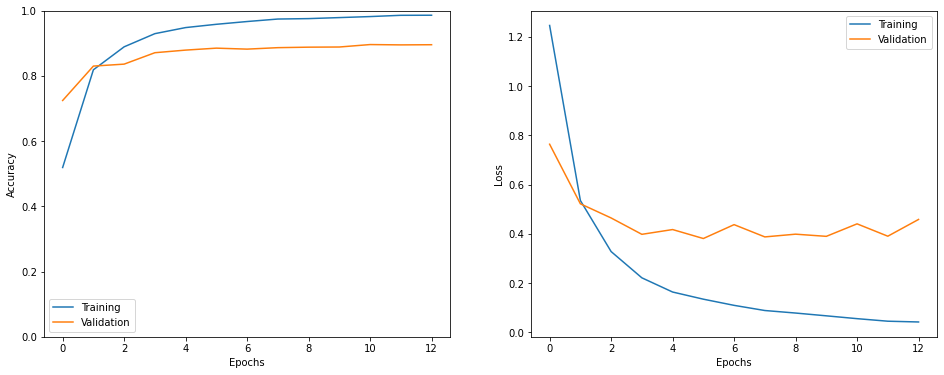

In [26]:
show_history(h)

In [27]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [28]:
_ = model.evaluate(test_sequences, test_labels)

63/63 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.90 - ETA: 1s - loss: 0.4185 - accuracy: 0.93 - ETA: 1s - loss: 0.5916 - accuracy: 0.89 - ETA: 1s - loss: 0.5212 - accuracy: 0.90 - ETA: 1s - loss: 0.5340 - accuracy: 0.90 - ETA: 1s - loss: 0.5385 - accuracy: 0.90 - ETA: 1s - loss: 0.5183 - accuracy: 0.90 - ETA: 1s - loss: 0.5498 - accuracy: 0.89 - ETA: 1s - loss: 0.5796 - accuracy: 0.88 - ETA: 1s - loss: 0.5346 - accuracy: 0.89 - ETA: 1s - loss: 0.5502 - accuracy: 0.88 - ETA: 1s - loss: 0.5417 - accuracy: 0.88 - ETA: 1s - loss: 0.5228 - accuracy: 0.88 - ETA: 1s - loss: 0.5405 - accuracy: 0.88 - ETA: 1s - loss: 0.5269 - accuracy: 0.88 - ETA: 0s - loss: 0.4976 - accuracy: 0.89 - ETA: 0s - loss: 0.5094 - accuracy: 0.89 - ETA: 0s - loss: 0.5059 - accuracy: 0.88 - ETA: 0s - loss: 0.5054 - accuracy: 0.88 - ETA: 0s - loss: 0.5077 - accuracy: 0.88 - ETA: 0s - loss: 0.5088 - accuracy: 0.88 - ETA: 0s - loss: 0.4983 - accuracy: 0.88 - ETA: 0s - loss: 0.5026 - accuracy: 

In [29]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_classes[test_labels[i]])

p = model.predict_classes(np.expand_dims(test_sequences[i], axis=0))[0]

print('Predicted Emotion:', index_to_classes.get(p))

Sentence: i feel so fearless in these post grieving days
Emotion: joy
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Predicted Emotion: joy


In [30]:
preds = model.predict_classes(test_sequences)
preds.shape, test_labels.shape

((2000,), (2000,))

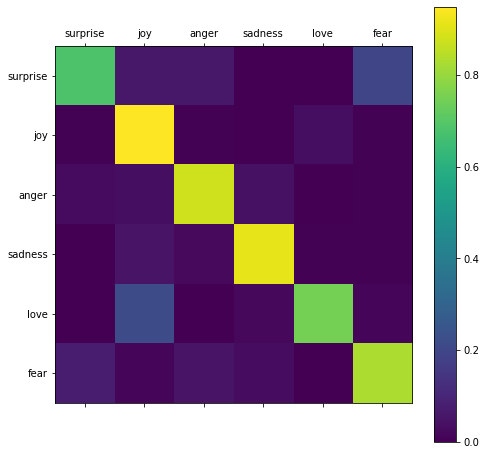

In [31]:
show_confusion_matrix(test_labels, preds, list(classes))